In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/gene-expression-prediction-cs1850-final/sample_submission.csv
/kaggle/input/gene-expression-prediction-cs1850-final/train.npz
/kaggle/input/gene-expression-prediction-cs1850-final/info.py
/kaggle/input/gene-expression-prediction-cs1850-final/eval.npz
/kaggle/input/gene-expression-prediction-cs1850-final/seq_data.csv


In [2]:
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, GlobalAveragePooling1D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping


2026-01-10 17:03:19.262696: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768064599.718440      23 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768064599.844135      23 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768064600.885180      23 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768064600.885219      23 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768064600.885221      23 computation_placer.cc:177] computation placer alr

In [3]:
SEED = 42

os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [4]:
#preview submission format

sub = pd.read_csv('/kaggle/input/gene-expression-prediction-cs1850-final/sample_submission.csv')
sub.head()

,id,expression
0,E065_115459,-0.062554
1,E065_162723,-0.083605
2,E065_196275,-0.575977
3,E065_232774,-0.233146
4,E065_172339,0.279043


In [5]:
sub.shape

(177032, 2)

In [6]:
#preview info file

with open ('/kaggle/input/gene-expression-prediction-cs1850-final/info.py','r') as f:
    print(f.read())

import numpy as np

# Keys to npzfile of train & eval
train_cells = ['E065', 'E004', 'E066', 'E005', 'E012', 'E027', 'E053', 'E013', 'E028', 'E061', 'E109', 'E120', 'E062', 'E037', 'E038', 'E024', 'E105', 'E011', 'E106', 'E082', 'E097', 'E116', 'E098', 'E058', 
'E117', 'E059', 'E070', 'E118', 'E085', 'E104', 'E119', 'E006', 'E127', 'E047', 'E094', 'E007', 'E054', 'E128', 'E095', 'E055', 'E114', 'E100', 'E056', 'E016', 'E122', 'E057', 'E123', 'E079', 'E003', 'E050']

eval_cells = ['E065', 'E004', 'E066', 'E005', 'E012', 'E027', 'E053', 'E013', 'E028', 'E061', 'E109', 'E120', 'E062', 'E037', 'E038', 'E024', 'E071', 'E105', 'E087', 'E011', 'E106', 'E096', 'E082', 'E097', 
'E116', 'E098', 'E058', 'E117', 'E084', 'E059', 'E070', 'E118', 'E085', 'E104', 'E119', 'E006', 'E112', 'E127', 'E047', 'E094', 'E007', 'E054', 'E113', 'E128', 'E095', 'E055', 'E114', 'E100', 'E056', 'E016', 'E122', 'E057', 'E123', 'E079', 'E003', 'E050']

# Load data
train_data = np.load('train.npz')
eval_data = np.load

In [7]:
#load training data
train_data = np.load('/kaggle/input/gene-expression-prediction-cs1850-final/train.npz',allow_pickle=True)
len(train_data.files)

50

In [8]:
eval_data = np.load('/kaggle/input/gene-expression-prediction-cs1850-final/eval.npz',allow_pickle=True)
len(eval_data.files)

56

In [9]:
#Explore the training data
train_data.files[:5]

['E065', 'E004', 'E066', 'E005', 'E012']

In [10]:
#select one cell type and check its shape
E065 = train_data['E065']
E065.shape

(16000, 100, 7)

In [11]:
#preview the 1st gene, second bin, all columns of E065 cell type
E065[0,1,:]

array([ 3.       ,  0.       ,  0.6931472,  0.       ,  0.       ,
        0.6931472, -2.9263823], dtype=float32)

- **First column:** gene ID
- **Second-sixth columns:** histone modification measurements
- **Seventh column:** gene expression

In [12]:
# Gene ID is constant across bins
print(np.unique(E065[0, :, 0]))

# Expression value is constant across bins
print(np.unique(E065[0, :, 6]))

[3.]
[-2.9263823]


In [13]:
# Separate target and features
histone_features = E065[:,:,1:6]
Expression = E065[:,:,6]
print(histone_features.shape)
print(Expression.shape)

(16000, 100, 5)
(16000, 100)


- 16000 genes
- 100 bins
- 5 histone markers

In [14]:
# Keys to npzfile of train & eval
train_cells = ['E065', 'E004', 'E066', 'E005', 'E012', 'E027', 'E053', 'E013', 'E028', 'E061', 'E109', 'E120',
               'E062', 'E037', 'E038', 'E024', 'E105', 'E011', 'E106', 'E082', 'E097', 'E116', 'E098', 'E058', 
'E117', 'E059', 'E070', 'E118', 'E085', 'E104', 'E119', 'E006', 'E127', 'E047', 'E094', 'E007', 'E054', 'E128',
               'E095', 'E055', 'E114', 'E100', 'E056', 'E016', 'E122', 'E057', 'E123', 'E079', 'E003', 'E050']

eval_cells = ['E065', 'E004', 'E066', 'E005', 'E012', 'E027', 'E053', 'E013', 'E028', 'E061', 'E109', 'E120', 
              'E062', 'E037', 'E038', 'E024', 'E071', 'E105', 'E087', 'E011', 'E106', 'E096', 'E082', 'E097', 
'E116', 'E098', 'E058', 'E117', 'E084', 'E059', 'E070', 'E118', 'E085', 'E104', 'E119', 'E006', 'E112', 'E127',
              'E047', 'E094', 'E007', 'E054', 'E113', 'E128', 'E095', 'E055', 'E114', 'E100', 'E056', 'E016', 'E122',
              'E057', 'E123', 'E079', 'E003', 'E050']

In [15]:
# Combine Train Data to use information from all cells
train_inputs = [] # Input histone mark data
train_outputs = [] # Correct expression value
for cell in train_cells:
    cell_data = train_data[cell]
    hm_data = cell_data[:,:,1:6]
    hm_flat = hm_data.reshape(hm_data.shape[0], -1)
    exp_values = cell_data[:,0,6]
    train_inputs.append(hm_flat)
    train_outputs.append(exp_values)

train_inputs = np.concatenate(train_inputs, axis=0)
train_outputs = np.concatenate(train_outputs, axis=0)

In [16]:
print(train_inputs.shape)
print(train_outputs.shape)

(800000, 500)
(800000,)


In [17]:
# Prepare Eval inputs in a similar way
eval_inputs = []
for cell in eval_cells:
    cell_data = eval_data[cell]
    hm_data = cell_data[:,:,1:6]
    hm_flat = hm_data.reshape(hm_data.shape[0], -1)
    eval_inputs.append(hm_flat)

eval_inputs = np.concatenate(eval_inputs, axis=0)

In [18]:
print(eval_inputs.shape)

(177032, 500)


In [19]:
#explore the expression values statistically

print("Mean:", np.mean(train_outputs))
print("Std:", np.std(train_outputs))
print("Min:", np.min(train_outputs))
print("Max:", np.max(train_outputs))

Mean: -0.27236924
Std: 1.8670437
Min: -5.204512
Max: 10.710043


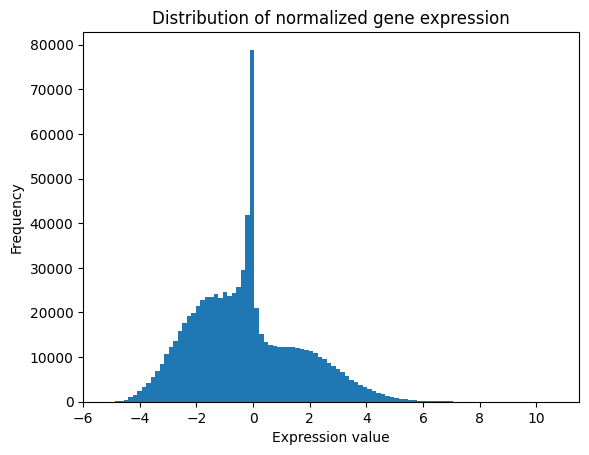

In [20]:
# visualize the distribution
plt.hist(train_outputs, bins=100)
plt.xlabel("Expression value")
plt.ylabel("Frequency")
plt.title("Distribution of normalized gene expression")
plt.show()

# Model Building

### Baseline Model

In [21]:
# Train/validation split
X_train, X_val, y_train, y_val = train_test_split(train_inputs,train_outputs,test_size=0.2, random_state=42)

In [22]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(640000, 500)
(160000, 500)
(640000,)
(160000,)


In [23]:
model = Ridge(alpha=1.0)

model.fit(X_train, y_train)

y_pred = model.predict(X_val)

mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print("MSE:", mse)
print("R²:", r2)

MSE: 3.3424179553985596
R²: 0.04120439291000366


# Build 1D CNN model

In [24]:
#converting the training data shape back to its original shape
X = train_inputs.reshape(800000, 100, 5)
#converting the evaluation data shape back to its original shape
y = train_outputs

In [25]:
#scaling the target
scaler = StandardScaler()
y_scaled = scaler.fit_transform(y.reshape(-1, 1)).ravel()

In [26]:
#train/validate split
X_train, X_val, y_train, y_val = train_test_split(X, y_scaled, test_size=0.2, random_state=42)

In [27]:
#Cov1D structure

model = Sequential([
    Conv1D(32,kernel_size = 5,padding="same", activation = 'relu', input_shape = (100,5)),

    Conv1D(64,kernel_size = 5, padding="same", activation = 'relu'),
    MaxPooling1D(pool_size = 2),

    Conv1D(128, kernel_size=7, padding="same", activation="relu"),
    BatchNormalization(),
    GlobalAveragePooling1D(),

    
    Dense(128, activation = 'relu'),
    Dropout(0.2),

    Dense(1, activation = 'linear')
])

model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4),
    loss = 'mse',
    metrics = ['mse']
)

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1768064636.770737      23 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1768064636.774494      23 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 100, 32)        │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 100, 64)        │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 50, 128)        │        57,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 50, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 85,761 (335.00 KB)

 Trainable params: 85,505 (334.00 KB)

 Non-trainable params: 256 (1.00 KB)

In [28]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,   
    restore_best_weights=True
)


In [29]:
#train 

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=64,
    verbose=1,
    callbacks=[early_stop]
)

Epoch 1/50


I0000 00:00:1768064643.438488      66 service.cc:152] XLA service 0x7c1108002420 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1768064643.438524      66 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1768064643.438528      66 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1768064643.924634      66 cuda_dnn.cc:529] Loaded cuDNN version 91002


   46/10000 ━━━━━━━━━━━━━━━━━━━━ 33s 3ms/step - loss: 1.1025 - mse: 1.1025

I0000 00:00:1768064647.693210      66 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


10000/10000 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - loss: 0.9534 - mse: 0.9534 - val_loss: 0.9282 - val_mse: 0.9282
Epoch 2/50
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 35s 3ms/step - loss: 0.9237 - mse: 0.9237 - val_loss: 0.9201 - val_mse: 0.9201
Epoch 3/50
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 35s 3ms/step - loss: 0.9145 - mse: 0.9145 - val_loss: 0.9096 - val_mse: 0.9096
Epoch 4/50
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 35s 4ms/step - loss: 0.9080 - mse: 0.9080 - val_loss: 0.9084 - val_mse: 0.9084
Epoch 5/50
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 35s 3ms/step - loss: 0.9018 - mse: 0.9018 - val_loss: 0.9011 - val_mse: 0.9011
Epoch 6/50
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 35s 3ms/step - loss: 0.8972 - mse: 0.8972 - val_loss: 0.9030 - val_mse: 0.9030
Epoch 7/50
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 35s 3ms/step - loss: 0.8927 - mse: 0.8927 - val_loss: 0.8991 - val_mse: 0.8991
Epoch 8/50
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 34s 3ms/step - loss: 0.8880 - mse: 0.8880 - val_loss: 0.9000 - val_mse: 0.9000
Epoch 9/50
10000/10000 ━━━━

In [30]:
# evaluate 
y_val_pred = model.predict(X_val).ravel()

mse = mean_squared_error(y_val, y_val_pred)
r2 = r2_score(y_val, y_val_pred)

print(f"MSE: {mse:.3f}")
print(f"R²: {r2:.3f}")

5000/5000 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
MSE: 0.899
R²: 0.101
